In [1]:
import os
import glob
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import lightly
import lightly.utils.io as io
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np
import json
import pandas as pd
from pathlib import Path

import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp

import torchvision.transforms.functional as functional

from sklearn import random_projection


In [6]:
#merge provenance and embeddings

def filepath_to_id(fname):
    fname = str(fname).split('/')[-1].split('.')[0]    
    fname = fname.replace('[ph]','/')
    return fname

embeddings_path = '/home/jcejudo/projects/image_classification/results/self_supervised/embeddings.csv'
provenance_df_path = '/home/jcejudo/projects/image_classification/data/single_label/training_data.csv'

#load provenance df
provenance_df = pd.read_csv(provenance_df_path)

#load embeddings
embeddings_df = pd.read_csv(embeddings_path)
embeddings_df = embeddings_df.drop_duplicates(subset='filenames', keep="first")
embeddings_df['ID'] = embeddings_df['filenames'].apply(filepath_to_id)

embeddings_df = embeddings_df.merge(provenance_df, left_on='ID', right_on='ID')
embeddings_df = embeddings_df.drop_duplicates(subset='ID', keep="first")

print(embeddings_df['ID'].values[0])
print(embeddings_df.shape)











/2024914/photography_ProvidedCHO_Ajuntament_de_Girona_065537
(69670, 519)


In [7]:
embeddings_df[['ID','URI','URL']].head()

ID  \
0  /2024914/photography_ProvidedCHO_Ajuntament_de...   
2  /2024914/photography_ProvidedCHO_Ajuntament_de...   
3  /2024914/photography_ProvidedCHO_Ajuntament_de...   
4  /2024914/photography_ProvidedCHO_Ajuntament_de...   
5  /2024914/photography_ProvidedCHO_Ajuntament_de...   

                                                 URI  \
0  http://data.europeana.eu/item/2024914/photogra...   
2  http://data.europeana.eu/item/2024914/photogra...   
3  http://data.europeana.eu/item/2024914/photogra...   
4  http://data.europeana.eu/item/2024914/photogra...   
5  http://data.europeana.eu/item/2024914/photogra...   

                                               URL  
0  http://sgdap.girona.cat/sdam/imatges/065537.jpg  
2  http://sgdap.girona.cat/sdam/imatges/084444.jpg  
3  http://sgdap.girona.cat/sdam/imatges/084464.jpg  
4  http://sgdap.girona.cat/sdam/imatges/084867.jpg  
5  http://sgdap.girona.cat/sdam/imatges/084951.jpg

In [47]:
data_path = '/home/jcejudo/projects/image_classification/data/single_label/images_training'


In [42]:

fname_list = []
path = Path(data_path)
for cat in path.glob('*'):
    for path in cat.glob('*'):
        fname_list.append("/".join([cat.name,path.name]))
        
print(len(fname_list))
print(len(list(set(fname_list))))


69841
69841


In [44]:
fname_list = []
path = Path(data_path)
for cat in path.glob('*'):
    for path in cat.glob('*'):
        fname_list.append(path.name)
        
print(len(fname_list))
print(len(list(set(fname_list))))

69841
69687


In [40]:
fname_list

['building/[ph]916123[ph]SLM_item_392227.jpg',
 'building/[ph]2022608[ph]ROM_R_Fot_49338.jpg',
 'building/[ph]2022608[ph]ROM_R_Fot_01093.jpg',
 'building/[ph]2022608[ph]ROM_R_Fot_49535.jpg',
 'building/[ph]916121[ph]S_OLM_photo_OLM_2003_25_1993.jpg',
 'building/[ph]2020708[ph]CA_BA12857_65_20_5.jpg',
 'building/[ph]2022608[ph]ROM_080576.jpg',
 'building/[ph]323[ph]S_BL_photo_BLMASV000154.jpg',
 'building/[ph]2022608[ph]ROM_1983_45_017.jpg',
 'building/[ph]2024904[ph]https___www_topfoto_co_uk_asset_3033628.jpg',
 'building/[ph]2022608[ph]ROM_R_Fot_34291.jpg',
 'building/[ph]2020708[ph]CA_BA12857_8_6_04.jpg',
 'building/[ph]154[ph]S_JVM_photo_JvmKBDB12914.jpg',
 'building/[ph]2022608[ph]ROM_82157.jpg',
 'building/[ph]2022608[ph]ROM_R_Fot_38355.jpg',
 'building/[ph]76[ph]jlm_item_273708.jpg',
 'building/[ph]2022608[ph]ROM_R_Fot_18918.jpg',
 'building/[ph]437[ph]item_YOQD33QBE23RVG3A3SRT5S33YWOJMG7Z.jpg',
 'building/[ph]2022608[ph]LE_LEM_016_370.jpg',
 'building/[ph]916121[ph]S_OLM_photo_O

In [56]:
data_path = '/home/jcejudo/projects/image_classification/data/single_label/images_training'
embeddings_path = '/home/jcejudo/projects/image_classification/results/self_supervised/embeddings.csv'


In [67]:

df = pd.read_csv(embeddings_path)
df = df.drop_duplicates(subset='filenames', keep="first")
embeddings = df[[c for c in df.columns if 'embedding' in c]].values
embeddings = normalize(embeddings)
filenames = list(df['filenames'].values)

In [69]:
len(filenames)

44169

In [58]:
filenames

['drawing/[ph]03919[ph]public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50410006585.jpg',
 'ceramics/[ph]2048087[ph]ProvidedCHO_British_Museum_and_The_Portable_Antiquities_Scheme_WAW_B81963.jpg',
 'toy/[ph]2022608[ph]NF_NF_1908_0441.jpg',
 'postcard/[ph]401[ph]item_LRUJ4MGDNUX65KX3WKQXHFYWWG6FI7FD.jpg',
 'photograph/[ph]09426[ph]206AF73E3645AB864E4B320AA5E9DEFD9D89F31A.jpg',
 'sculpture/[ph]91619[ph]SMVK_EM_objekt_1059232.jpg',
 'photograph/[ph]2021633[ph]AtlantisPubliek_detail_aspx_xmldescid_14734697.jpg',
 'photograph/[ph]2021650[ph]memorix_32e53d2a_eb18_11df_a391_13966e870614.jpg',
 'jewellery/[ph]91619[ph]SMVK_EM_objekt_1298349.jpg',
 'furniture/[ph]154[ph]S_JVM_photo_JvmKBAA06711.jpg',
 'building/[ph]76[ph]jlm_item_264059.jpg',
 'building/[ph]2024904[ph]https___www_topfoto_co_uk_asset_3007990.jpg',
 'toy/[ph]2058618[ph]object_KUAS_22187177.jpg',
 'archaeological_site/[ph]330[ph]RAN_62495_01.jpg',
 'painting/[ph]90402[ph]SK_A_5008.jpg',
 'furniture/[ph]188[ph]item_5CCX

In [59]:
len(filenames)

69824

In [64]:
count_dict = {}
for fname in filenames:
    if fname not in count_dict.keys():
        count_dict.update({fname:1})
    else:
        count_dict[fname] += 1

count_dict

{'drawing/[ph]03919[ph]public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50410006585.jpg': 3,
 'ceramics/[ph]2048087[ph]ProvidedCHO_British_Museum_and_The_Portable_Antiquities_Scheme_WAW_B81963.jpg': 1,
 'toy/[ph]2022608[ph]NF_NF_1908_0441.jpg': 1,
 'postcard/[ph]401[ph]item_LRUJ4MGDNUX65KX3WKQXHFYWWG6FI7FD.jpg': 2,
 'photograph/[ph]09426[ph]206AF73E3645AB864E4B320AA5E9DEFD9D89F31A.jpg': 5,
 'sculpture/[ph]91619[ph]SMVK_EM_objekt_1059232.jpg': 4,
 'photograph/[ph]2021633[ph]AtlantisPubliek_detail_aspx_xmldescid_14734697.jpg': 2,
 'photograph/[ph]2021650[ph]memorix_32e53d2a_eb18_11df_a391_13966e870614.jpg': 1,
 'jewellery/[ph]91619[ph]SMVK_EM_objekt_1298349.jpg': 2,
 'furniture/[ph]154[ph]S_JVM_photo_JvmKBAA06711.jpg': 1,
 'building/[ph]76[ph]jlm_item_264059.jpg': 2,
 'building/[ph]2024904[ph]https___www_topfoto_co_uk_asset_3007990.jpg': 3,
 'toy/[ph]2058618[ph]object_KUAS_22187177.jpg': 2,
 'archaeological_site/[ph]330[ph]RAN_62495_01.jpg': 1,
 'painting/[ph]90402[ph]SK_A_5

In [60]:
len(list(set(filenames)))

44169

In [61]:
list(set(filenames))

['sculpture/[ph]91669[ph]SMVK_OM_Bildarkiv_608447.jpg',
 'clothing/[ph]2064105[ph]Museu_ProvidedCHO_Hallwylska_museet_8075.jpg',
 'map/[ph]9200387[ph]BibliographicResource_3000117285353.jpg',
 'photograph/[ph]2021650[ph]memorix_19561e03_f2d7_faff_c167_09165a67d4cd.jpg',
 'photograph/[ph]2021663[ph]memorix_3680610a_a5a9_42b9_aba5_7c93fe7cd553.jpg',
 'painting/[ph]03919[ph]public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_000PE011530.jpg',
 'weaponry/[ph]2064105[ph]Museu_ProvidedCHO_Livrustkammaren_42917.jpg',
 'postcard/[ph]122[ph]https___www_searchculture_gr_aggregator_edm_ELIA_000100_22_432529.jpg',
 'toy/[ph]2022608[ph]NF_NF_1929_0538.jpg',
 'photograph/[ph]2021647[ph]beeldbank_weergave_record_id_0c2e6536_2c30_dfac_d48e_6eae918ff2ab.jpg',
 'map/[ph]916121[ph]S_OLM_photo_OLM_2013_1_111.jpg',
 'toy/[ph]2022608[ph]NF_NF_1955_0096.jpg',
 'postcard/[ph]249[ph]item_LJ2JQ3TLQH7CUBSVZGGFH7JCJDGG7PLX.jpg',
 'textile/[ph]2022608[ph]MH_SS_46658.jpg',
 'painting/[ph]2022608[ph]VTM_LB

In [4]:
df.shape

(69824, 514)

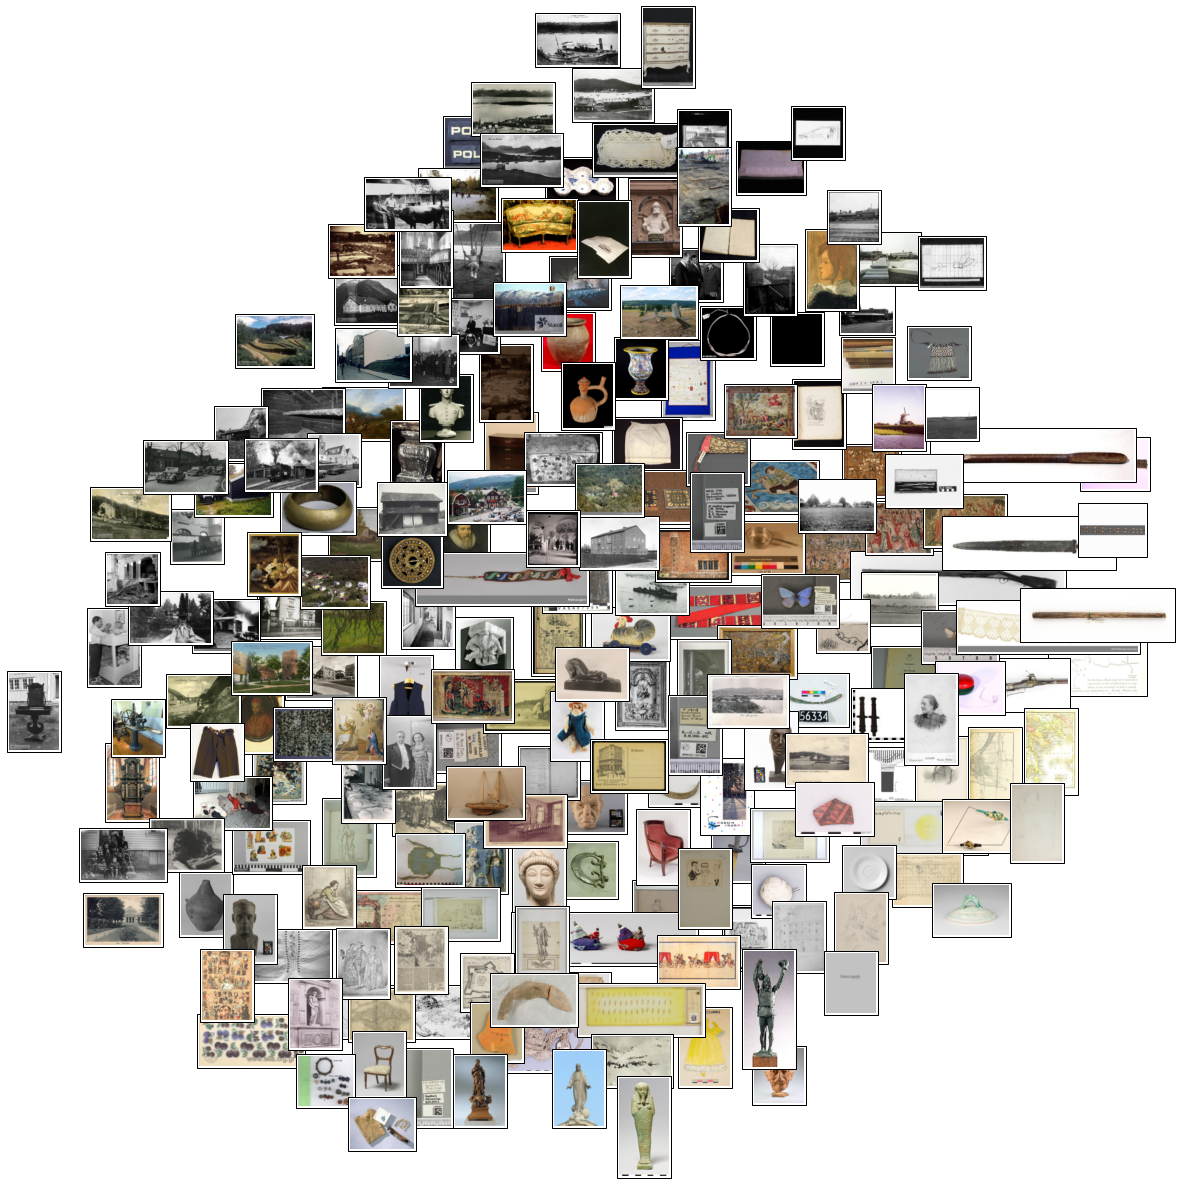

In [71]:
# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays.
    """
    figsize = (20,20)
    # initialize empty figure and add subplot
    fig = plt.figure(figsize = figsize)
    #fig.suptitle('Scatter Plot')
    ax = fig.add_subplot(1, 1, 1)
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # plot image overlays
    for idx in shown_images_idx:
        #thumbnail_size = int(rcp['figure.figsize'][0] * 4.)
        thumbnail_size = 50
        #print(thumbnail_size)
        path = os.path.join(data_path, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # set aspect ratio
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')
    ax.axis('off')


# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()

In [52]:
filenames[1]

'[ph]03919[ph]public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_000SC003466.jpg'

query
http://data.europeana.eu/item/09403/o_gm_2413_CHO
http://data.europeana.eu/item/2021663/memorix_04f3493e_34bc_36c0_416d_c2688abd45e7
http://data.europeana.eu/item/09403/o_gm_4830_CHO
http://data.europeana.eu/item/916121/S_OLM_photo_OLM_1942_76
http://data.europeana.eu/item/09403/o_gm_8620_CHO
http://data.europeana.eu/item/09403/o_gm_768_CHO
http://data.europeana.eu/item/09403/o_gm_3740_CHO
http://data.europeana.eu/item/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50170000860
http://data.europeana.eu/item/09403/o_gm_7793_CHO
query
http://data.europeana.eu/item/92062/BibliographicResource_1000126108207
http://data.europeana.eu/item/92062/BibliographicResource_1000126096585
http://data.europeana.eu/item/401/item_HFJD5FJG7FDW4F6MRRDH6L2XOC3HYFO2
http://data.europeana.eu/item/401/item_ZVIT6VVIAWWEB6SESVU2FNHOYV55KLGY
http://data.europeana.eu/item/92062/BibliographicResource_1000126147964
http://data.europeana.eu/item/90402/RP_T_1969_598
http://data.europeana.eu/

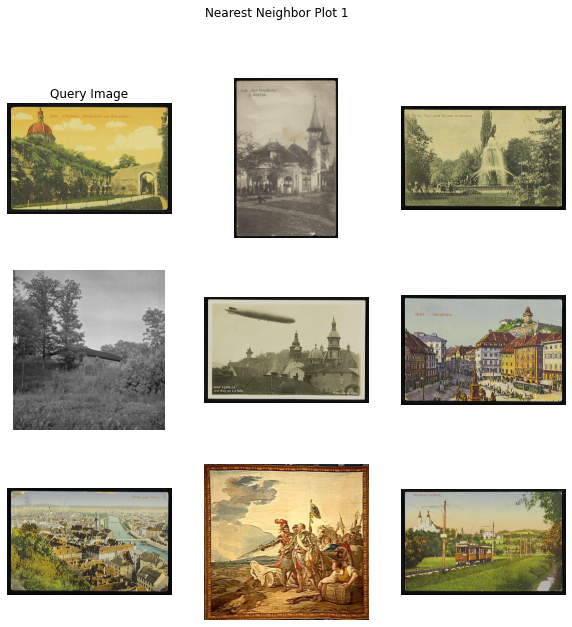

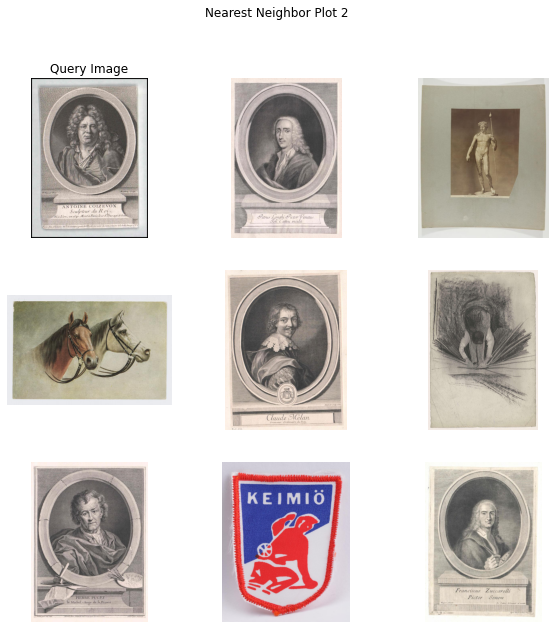

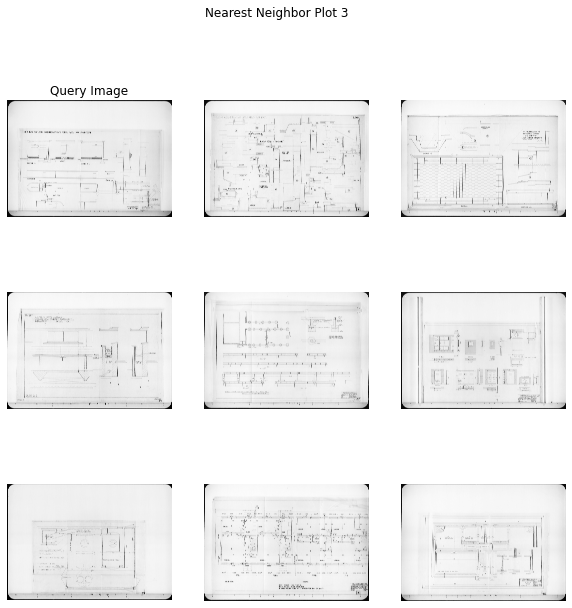

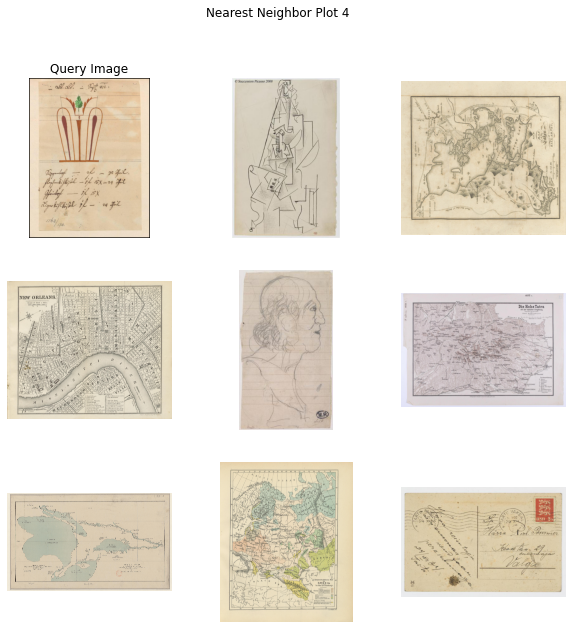

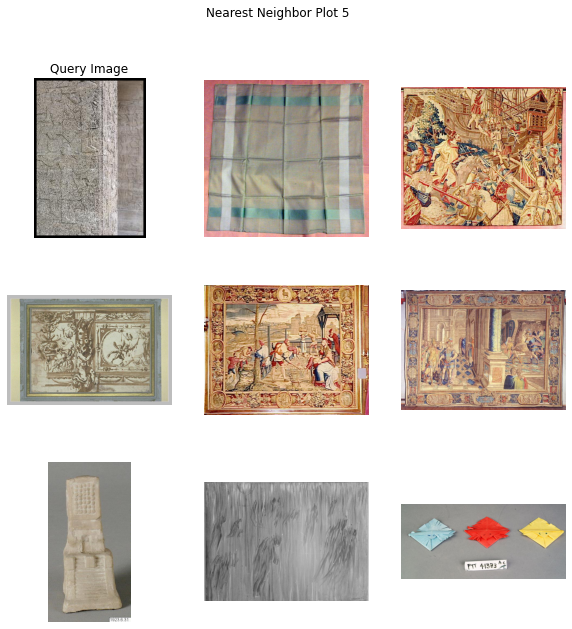

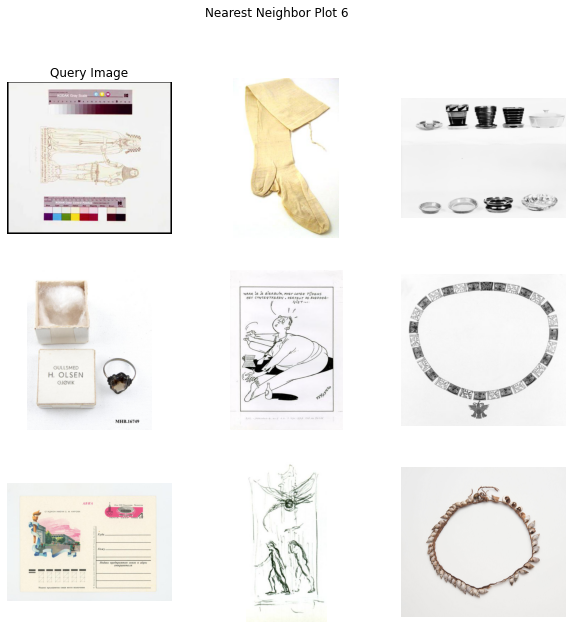

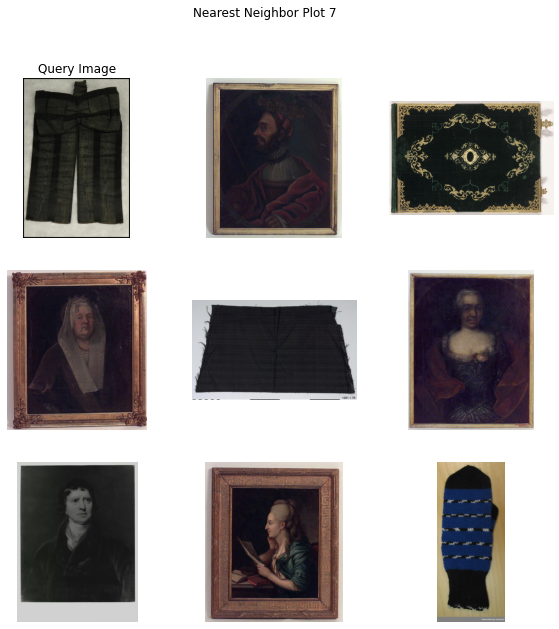

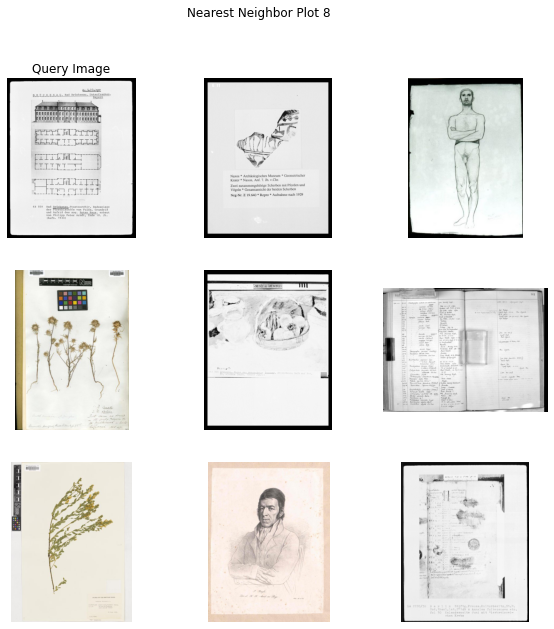

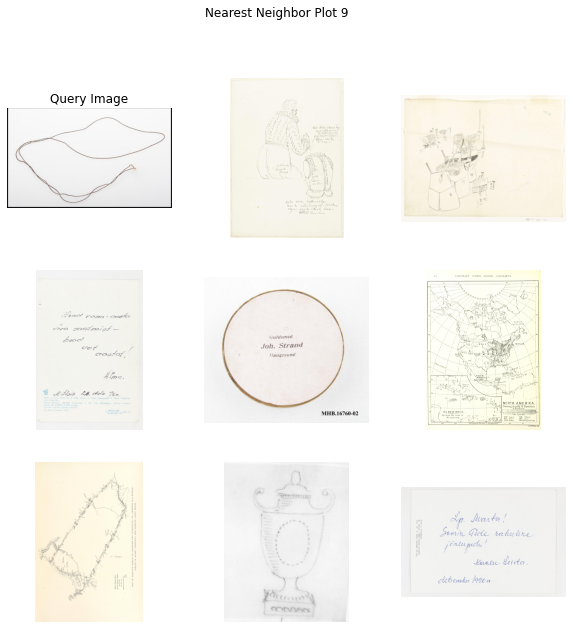

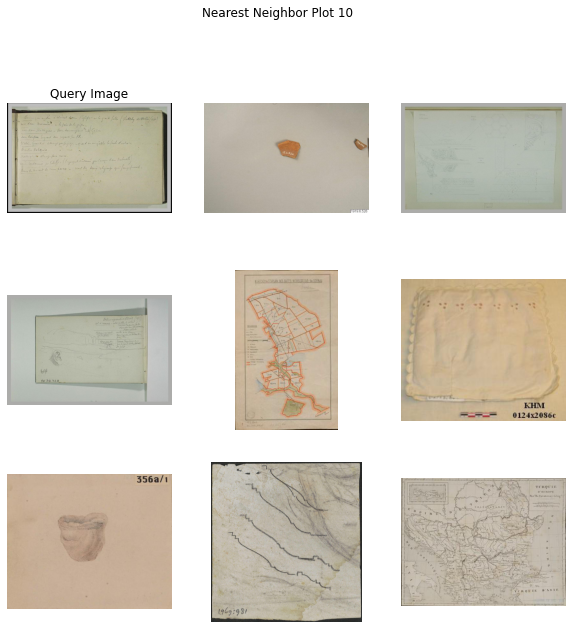

In [70]:
N = 10

idx = np.random.randint(len(filenames),size = N)

example_images = [filenames[i] for i in idx]

# example_images = [
#     '[ph]02030[ph]MatrizNet_Objectos_ObjectosConsultar_aspx_IdReg_208543.jpg', # water 1
#     '[ph]03919[ph]public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_000SC003466.jpg', # water 2
#     #'S2B_MSIL1C_20200526T101559_N0209_R065_T32TNL/tile_00556.png', # land
#     #'S2B_MSIL1C_20200526T101559_N0209_R065_T31SGD/tile_01731.png', # clouds 1
#     #'S2B_MSIL1C_20200526T101559_N0209_R065_T32SMG/tile_00238.png', # clouds 2
# ]


def get_image_as_np_array(filename: str):
    """Loads the image with filename and returns it as a numpy array.

    """
    img = Image.open(filename)
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """Returns an image as a numpy array with a black frame of width w.

    """
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape
    # create an empty image with padding for the frame
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)
    # put the original image in the middle of the new one
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_3x3(example_image: str, i: int):
    """Plots the example image and its eight nearest neighbors.

    """
    n_subplots = 9
    figsize = (10,10)
    # initialize empty figure
    fig = plt.figure(figsize = figsize)
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")
    #
    example_idx = filenames.index(example_image)
    # get distances to the cluster center
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()
    # sort indices by distance to the center
    nearest_neighbors = np.argsort(distances)[:n_subplots]
    # show images
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)
        # get the corresponding filename
        fname = os.path.join(data_path, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Query Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
            
            print('query')
            id = Path(fname).with_suffix('').name.replace('[ph]','/')
            uri = 'http://data.europeana.eu/item'
            print(uri+id)
            
        else:
            plt.imshow(get_image_as_np_array(fname))
            
            
            id = Path(fname).with_suffix('').name.replace('[ph]','/')
            uri = 'http://data.europeana.eu/item'
            print(uri+id)
        # let's disable the axis
        plt.axis("off")
        
    plt.plot()


# show example images for each cluster
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_3x3(example_image, i)
    plt.plot()
    

In [17]:
df.columns

df['labels']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
8658   NaN
8659   NaN
8660   NaN
8661   NaN
8662   NaN
Name: labels, Length: 8663, dtype: float64

In [18]:
df.dropna()

Empty DataFrame
Columns: [filenames, embedding_0, embedding_1, embedding_2, embedding_3, embedding_4, embedding_5, embedding_6, embedding_7, embedding_8, embedding_9, embedding_10, embedding_11, embedding_12, embedding_13, embedding_14, embedding_15, embedding_16, embedding_17, embedding_18, embedding_19, embedding_20, embedding_21, embedding_22, embedding_23, embedding_24, embedding_25, embedding_26, embedding_27, embedding_28, embedding_29, embedding_30, embedding_31, embedding_32, embedding_33, embedding_34, embedding_35, embedding_36, embedding_37, embedding_38, embedding_39, embedding_40, embedding_41, embedding_42, embedding_43, embedding_44, embedding_45, embedding_46, embedding_47, embedding_48, embedding_49, embedding_50, embedding_51, embedding_52, embedding_53, embedding_54, embedding_55, embedding_56, embedding_57, embedding_58, embedding_59, embedding_60, embedding_61, embedding_62, embedding_63, embedding_64, embedding_65, embedding_66, embedding_67, embedding_68, embedding_69, embedding_70, embedding_71, embedding_72, embedding_73, embedding_74, embedding_75, embedding_76, embedding_77, embedding_78, embedding_79, embedding_80, embedding_81, embedding_82, embedding_83, embedding_84, embedding_85, embedding_86, embedding_87, embedding_88, embedding_89, embedding_90, embedding_91, embedding_92, embedding_93, embedding_94, embedding_95, embedding_96, embedding_97, embedding_98, ...]
Index: []

[0 rows x 514 columns]

In [19]:
df.shape

(8663, 514)

In [6]:
#load embeddings
embeddings, labels, filenames = io.load_embeddings(embeddings_path)

ValueError: invalid literal for int() with base 10: ''

In [3]:


#fit nearest neighbours
nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)

#load model
batch_size = 64
num_workers = 2
num_ftrs = 32
input_size = 128

collate_fn = lightly.data.SimCLRCollateFunction(
    input_size=input_size,
    vf_prob=0.5,
    rr_prob=0.5,
    cj_prob=0.0,
    random_gray_scale=0.0
)
dataset_train_simclr = lightly.data.LightlyDataset(
input_dir=data_path
)

dataloader_train_simclr = torch.utils.data.DataLoader(
dataset_train_simclr,
batch_size=batch_size,
shuffle=True,
collate_fn=collate_fn,
drop_last=True,
num_workers=num_workers
)

resnet = lightly.models.ResNetGenerator('resnet-18')
last_conv_channels = list(resnet.children())[-1].in_features
backbone = nn.Sequential(
    *list(resnet.children())[:-1],
    nn.Conv2d(last_conv_channels, num_ftrs, 1),
    nn.AdaptiveAvgPool2d(1)
)

model = lightly.models.SimCLR(backbone, num_ftrs=num_ftrs)
criterion = lightly.loss.NTXentLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
encoder = lightly.embedding.SelfSupervisedEmbedding(
    model,
    criterion,
    optimizer,
    dataloader_train_simclr

)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = encoder.to(device)
if device == 'cpu':
    encoder.model.load_state_dict(torch.load(model_path,map_location=device))
else:
    encoder.model.load_state_dict(torch.load(model_path))
encoder.model.eval()

NameError: name 'io' is not defined